# Multi-region Sparse Component Analysis (**mSCA**)

**mSCA** is a dimensionality reduction tool specifically designed for analyzing data from multiple brain regions.

**mSCA** has three defining features:

1.  **Inferring latent factors that occur sparsely in time:** For example, it can demarcate movement-related activity from preparatory activity, facilitating interpretation.

2.  **Identifying region-specific or shared latent factors:** mSCA determines whether each inferred latent factor is unique to a given brain region or shared across multiple regions.

3.  **Quantifying time-delays for shared latent factors:** For latent factors shared across regions, mSCA identifies the time-delays at which they appear in each region, revealing the correlational flow of information between brain regions.

This notebook will guide you through the basic functionality of mSCA and should be copied and adapted to get started with your own data. We will have an additional notebook walking through more rigorous (but more time-intensive) analyses in `./full_demo.ipynb`.

## Required package installations
* Follow the installation instructions in `README.md` before running the code below.

## Data formatting and example
* In order to fit mSCA and infer latents, your data should be in the following format:
    ```
    X = { 
        "region_1": [trial_1, trial_2, ..., trial_M], 
        "region_2": [trial_1, trial_2, ..., trial_M]
    }
    ```
* The keys of `X` should correspond to the names of the regions in your dataset.
* The values of `X` should be lists of `np.float32` arrays of shape `(t_j x N_i)`.
    * `t_j` is the number of time-points on trial `j`.
    * `N_i` is the number of neurons in region `i`.

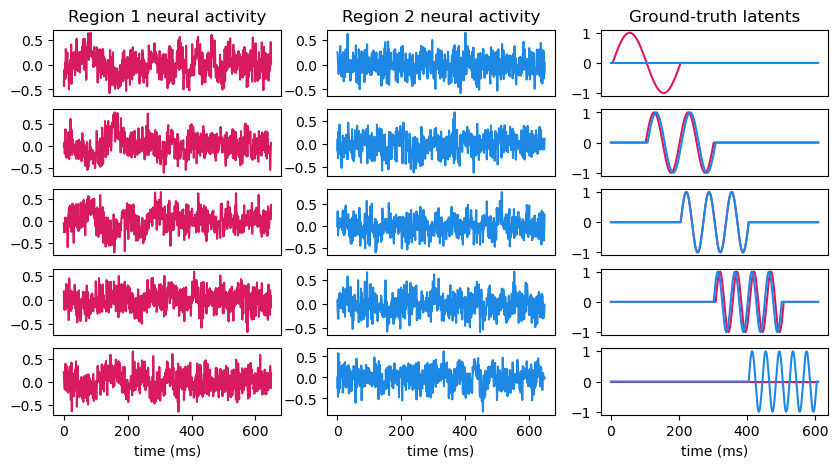

In [1]:
import matplotlib.pyplot as plt
from msca import *

# Generate noisy simulated firing-rates, ground-truth latents, and delays
X, Z_gt, delays_gt = simulate_trial_averages()

# Visualization + example accessing attributes of X
colors = ["#D81B60", "#1E88E5"]
num_viz = 5
fig, axs = plt.subplots(num_viz, 3, figsize=(10, 5))
for i in range(num_viz):
    axs[i, 0].plot(X["X0"][0][:, i], c=colors[0])
    axs[i, 1].plot(X["X1"][0][:, i], c=colors[1])
    axs[i, 2].plot(Z_gt["Z0"][:, i], c=colors[0])
    axs[i, 2].plot(Z_gt["Z1"][:, i], c=colors[1])

    if i == 0:
        axs[i, 0].set_title("Region 1 neural activity")
        axs[i, 1].set_title("Region 2 neural activity")
        axs[i, 2].set_title("Ground-truth latents")

    if i < num_viz-1:
        axs[i, 0].set_xticks([])
        axs[i, 1].set_xticks([])
        axs[i, 2].set_xticks([])
    else:
        axs[i, 0].set_xlabel("time (ms)")
        axs[i, 1].set_xlabel("time (ms)")
        axs[i, 2].set_xlabel("time (ms)")

## Training mSCA

* We're now going to train mSCA, using 1 additional dimension than was used to generate the training data to illustrate that mSCA is robust to the number of dimensions specified.
* If your data hasn't been pre-smoothed or trial-averaged in any way, add `loss_func="Poisson"` to the arguments passed into `mSCA()`.
* If you want to toggle any of the following hyperparameters `lam_sparse`, `lam_orthog`, or `lam_region`, you can pass your desired value as an argument to `mSCA()`. It's a good idea to keep the values you use within the range [0.0, 1.0].

In [2]:
msca, losses = mSCA(n_components=5+1, n_epochs=2000).fit(X)

/Users/andrewulmer/nuin/research/mSCA/msca/architectures.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.model.weight = torch.tensor(V_combined, dtype=torch.float32)


Using region-weights = {'X0': np.float64(0.9994517574377787), 'X1': np.float64(1.0005488443618995)}
Using lam_sparse = 0.18484989708703095
Using lam_orthog = 8391.827535941755
Using lam_region = 512.941452223603


100%|██████████| 2000/2000 [01:07<00:00, 29.43it/s]


## Visualize the losses to ensure the model converged

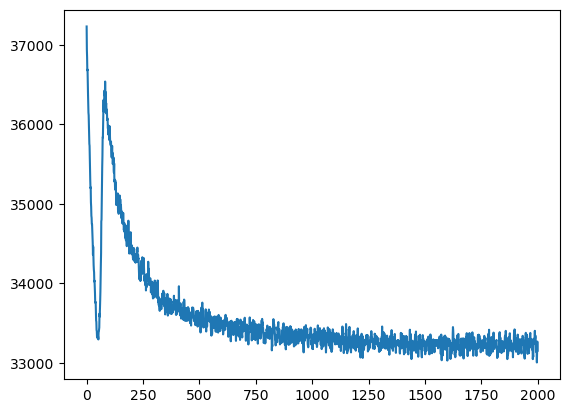

In [3]:
loss = np.stack([v for v in losses.values()], axis=1).sum(axis=1)
plt.plot(loss)

## Infer latents with trained mSCA model

* We're now going to use mSCA to infer latents and compare them to the ground-truth latents and corresponding time-delays.

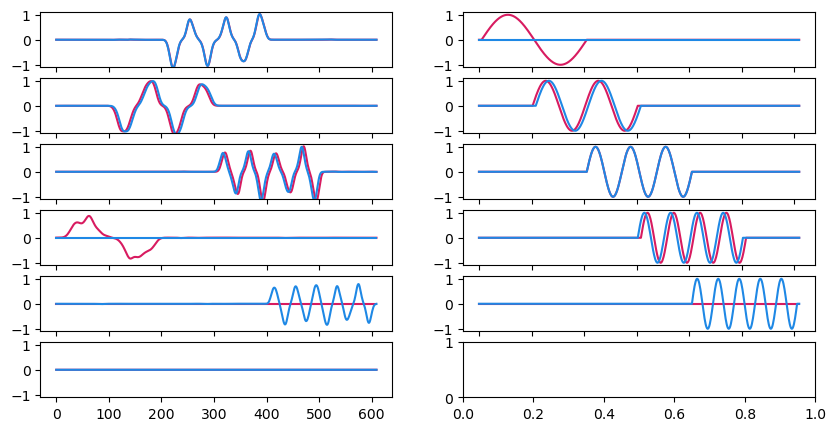

In [4]:
# First infer the latents
Z = msca.transform(X)

colors = ["#D81B60", "#1E88E5"]
fig, axs = plt.subplots(5+1, 2, figsize=(10, 5))

for i in range(6):

    axs[i, 0].plot(Z["X0"][0][:, i], c=colors[0])
    axs[i, 0].plot(Z["X1"][0][:, i], c=colors[1])
    axs[i, 0].set_ylim(-1.1, 1.1)

    if i < 5:
        axs[i, 1].plot(Z_gt["Z0"][:, i], c=colors[0])
        axs[i, 1].plot(Z_gt["Z1"][:, i], c=colors[1])
        axs[i, 1].set_ylim(-1.1, 1.1)

    # if i == 0:
    #     axs[i, 0].set_title("Region 1 neural activity")
    #     axs[i, 1].set_title("Region 2 neural activity")
    #     axs[i, 2].set_title("Ground-truth latents")

    # if i < num_viz - 1:
    #     axs[i, 0].set_xticks([])
    #     axs[i, 1].set_xticks([])
    #     axs[i, 2].set_xticks([])
    # else:
    #     axs[i, 0].set_xlabel("time (ms)")
    #     axs[i, 1].set_xlabel("time (ms)")
    #     axs[i, 2].set_xlabel("time (ms)")
# [
#     (plt.subplot(6, 1, i + 1), plt.plot(Z["X0"][0][:, i]), plt.ylim(-1.2, 1.2))
#     for i in range(6)
# ];
# [
#     (plt.subplot(6, 1, i + 1), plt.plot(Z["X1"][0][:, i]), plt.ylim(-1.2, 1.2))
#     for i in range(6)
# ];

## Check prediction quality
* We're now going to look and see how well the reconstructed neural activity captures the neural activity we input to the model

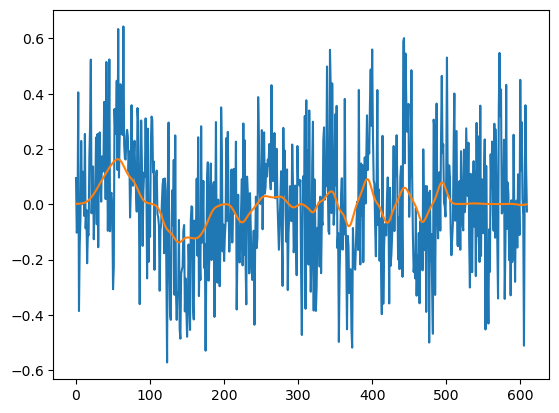

In [5]:
# Grab the reconstructions
X_hat = msca.predict(X)

# Check the quality of the reconstructions
plt.plot(X["X0"][0][msca.trunc, 0])
plt.plot(X_hat["X0"][0][:, 0])